# RRT STAR Path Planning

In [2]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Tree:
    """
    Tree
    """
    def __init__(self):
        self.vertices = []
        self.edges = []

    def add_vertex(self, point):
        self.vertices.append(point)

    def add_edge(self, point_idx):
        self.edges.append(point_idx)

In [4]:
class Environment:
    """
    Environment (Map, Obstacles)
    """
    def __init__(
        self, 
        x_min, 
        y_min, 
        x_max, 
        y_max
    ):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.obstacles = []

    def add_obstacle(self, obj):
        self.obstacles.extend(obj)

In [5]:
class RRTStar:
    """
    RRT path planning
    """
    def __init__(
        self, 
        env,
        start, 
        goal,
        delta_distance=0.5,
        epsilon=0.1,
        max_iter=3000,
        gamma_RRT_star=300, # At least gamma_RRT > delta_distance,
        dimension=2
    ):
        self.env = env
        self.start = start
        self.goal  = goal
        self.delta_dis = delta_distance
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.gamma_RRTs = gamma_RRT_star
        self.d = dimension
        self.T = Tree()
        self.testT = Tree()
        self.cost = {}

    def generate_path(self):
        path = None
        init_path = None
        self.T.add_vertex(self.start)
        self.testT.add_vertex(self.start)
        self.cost[0] = 0
        test_goal = False
        cnt = 0
        for k in range(self.max_iter):
            rand_point = self.random_state()
            nearest_point, nearest_idx = self.nearest_neighbor(rand_point, self.T)
            new_point = self.new_state(nearest_point, rand_point)

            if k % 500 == 0:
                print(f"iter : {k}")

            # Test
            #########################################################################################
            test_nearest_point, test_nearest_idx = self.nearest_neighbor(rand_point, self.testT)
            test_new_point = self.new_state(test_nearest_point, rand_point)

            if self.collision_free(test_nearest_point, test_new_point) and not test_goal:
                self.testT.add_vertex(test_new_point)
                test_new_idx = len(self.testT.vertices) - 1
                self.testT.add_edge([test_nearest_idx, test_new_idx])

                if self.reach_to_goal(test_new_point):
                    test_goal = True
            #########################################################################################

            if self.collision_free(nearest_point, new_point):
                neighbor_indexes = self.find_near_neighbor(new_point)                
                min_cost = self.get_new_cost(nearest_idx, nearest_point, new_point)

                min_cost, nearest_idx = self.get_minimum_cost(neighbor_indexes, new_point, min_cost, nearest_idx)
 
                self.T.add_vertex(new_point)
                new_idx = len(self.T.vertices) - 1
                self.cost[new_idx] = min_cost
                self.T.add_edge([nearest_idx, new_idx])
                self.rewire(neighbor_indexes, new_point, new_idx)

                if self.reach_to_goal(new_point):
                    cnt += 1
                    path = self.find_path(self.T)
                    if cnt == 1 :
                        init_path = path

        return path, init_path

    def random_state(self):
        if np.random.random() > self.epsilon:
            point = np.array([np.random.uniform(self.env.x_min, self.env.x_max),
                              np.random.uniform(self.env.y_min, self.env.y_max)]) 
        else:
            point = self.goal
        return point

    def nearest_neighbor(self, random_point, tree):
        distances = [self.distance(random_point, point) 
                     for point in tree.vertices]
        nearest_idx = np.argmin(distances)
        nearest_point = tree.vertices[nearest_idx]
        return nearest_point, nearest_idx

    def distance(self, pointA, pointB):
        return np.linalg.norm(pointB - pointA)

    def new_state(self, nearest_point, random_point):
        if np.equal(nearest_point, random_point).all():
            return nearest_point

        vector = random_point - nearest_point
        dist = self.distance(random_point, nearest_point)
        step = min(self.delta_dis, dist)
        unit_vector = vector / dist
        new_point = nearest_point + unit_vector * step

        return new_point

    # TODO
    # use fcl lib
    def collision_free(self, pointA, pointB):
        for (obs_x, obs_y, obs_r) in self.env.obstacles:
            if self.is_inside_circle(obs_x, obs_y, obs_r, pointB):
                return False
            if self.is_intersect_circle(obs_x, obs_y, obs_r, pointA, pointB):
                return False
        return True

    def is_inside_circle(self, x, y, r, point):
        obs_point = np.array([x, y])
        distances = self.distance(point, obs_point)
        if distances <= r + self.delta_dis:
            return True
        return False

    def is_intersect_circle(self, x, y, r, pointA, pointB):
        vectorAB = pointB - pointA
        distanceAB = self.distance(pointB, pointA)
        if distanceAB == 0:
            return False

        pointC = np.array([x, y])
        vectorAC = pointC - pointA
        proj = np.dot(vectorAC, vectorAB) / distanceAB
        proj = np.clip(proj, 0, 1)

        pointD = pointA + proj * vectorAB
        distancCD = self.distance(pointD, pointC)
        
        if distancCD <= r + self.delta_dis:
            return True
        return False

    def find_near_neighbor(self, point):
        card_V = len(self.T.vertices) + 1
        r = self.gamma_RRTs * ((math.log(card_V) / card_V) ** (1/self.d))
        search_radius = min(r, self.delta_dis)
        dist_list = [self.distance(vertex, point) for vertex in self.T.vertices]
                                                   
        near_indexes = []
        for idx, dist in enumerate(dist_list):
            if dist <= search_radius and self.collision_free(point, self.T.vertices[idx]):
                near_indexes.append(idx)

        return near_indexes

    def get_new_cost(self, idx, A, B):
        cost = self.cost[idx] + self.distance(A, B)
        return cost

    def get_minimum_cost(self, neighbor_indexes, new_point, min_cost, nearest_idx):
        for i in neighbor_indexes:
            new_cost = self.get_new_cost(i, new_point, self.T.vertices[i])

            if new_cost < min_cost and self.collision_free(new_point, self.T.vertices[i]):
                min_cost = new_cost
                nearest_idx = i

        return min_cost, nearest_idx

    def rewire(self, neighbor_indexes, new_point, new_idx):
        for i in neighbor_indexes:
            no_collision = self.collision_free(new_point, self.T.vertices[i])
            new_cost = self.get_new_cost(new_idx, new_point, self.T.vertices[i])

            if no_collision and new_cost < self.cost[i]:
                self.cost[i] = new_cost
                self.T.edges[i-1][0] = new_idx

    def reach_to_goal(self, point):
        dist = self.distance(point, self.goal)
        if dist <= 0.5:
            return True
        return False

    def find_path(self, tree):
        path = [self.goal]
        goal_idx = tree.edges[-1][1]
 
        while goal_idx != 0:
            path.append(tree.vertices[goal_idx])
            parent_idx = tree.edges[goal_idx-1][0]
            goal_idx = parent_idx
        path.append(self.start)

        return path[::-1]

    def get_rrt_tree(self):
        vertices = []
        for edge in self.T.edges:
            from_node = self.T.vertices[edge[0]]
            goal_node = self.T.vertices[edge[1]]
            vertices.append((from_node, goal_node))
        return vertices

    def test_get_rrt_tree(self):
        vertices = []
        for edge in self.testT.edges:
            from_node = self.testT.vertices[edge[0]]
            goal_node = self.testT.vertices[edge[1]]
            vertices.append((from_node, goal_node))
        return vertices

In [6]:
def plot_circle(x, y, size, color="-b"):
    deg = list(range(0, 360, 5))
    deg.append(0)
    xl = [x + size * np.cos(np.deg2rad(d)) for d in deg]
    yl = [y + size * np.sin(np.deg2rad(d)) for d in deg]
    plt.plot(xl, yl, color)

iter : 0


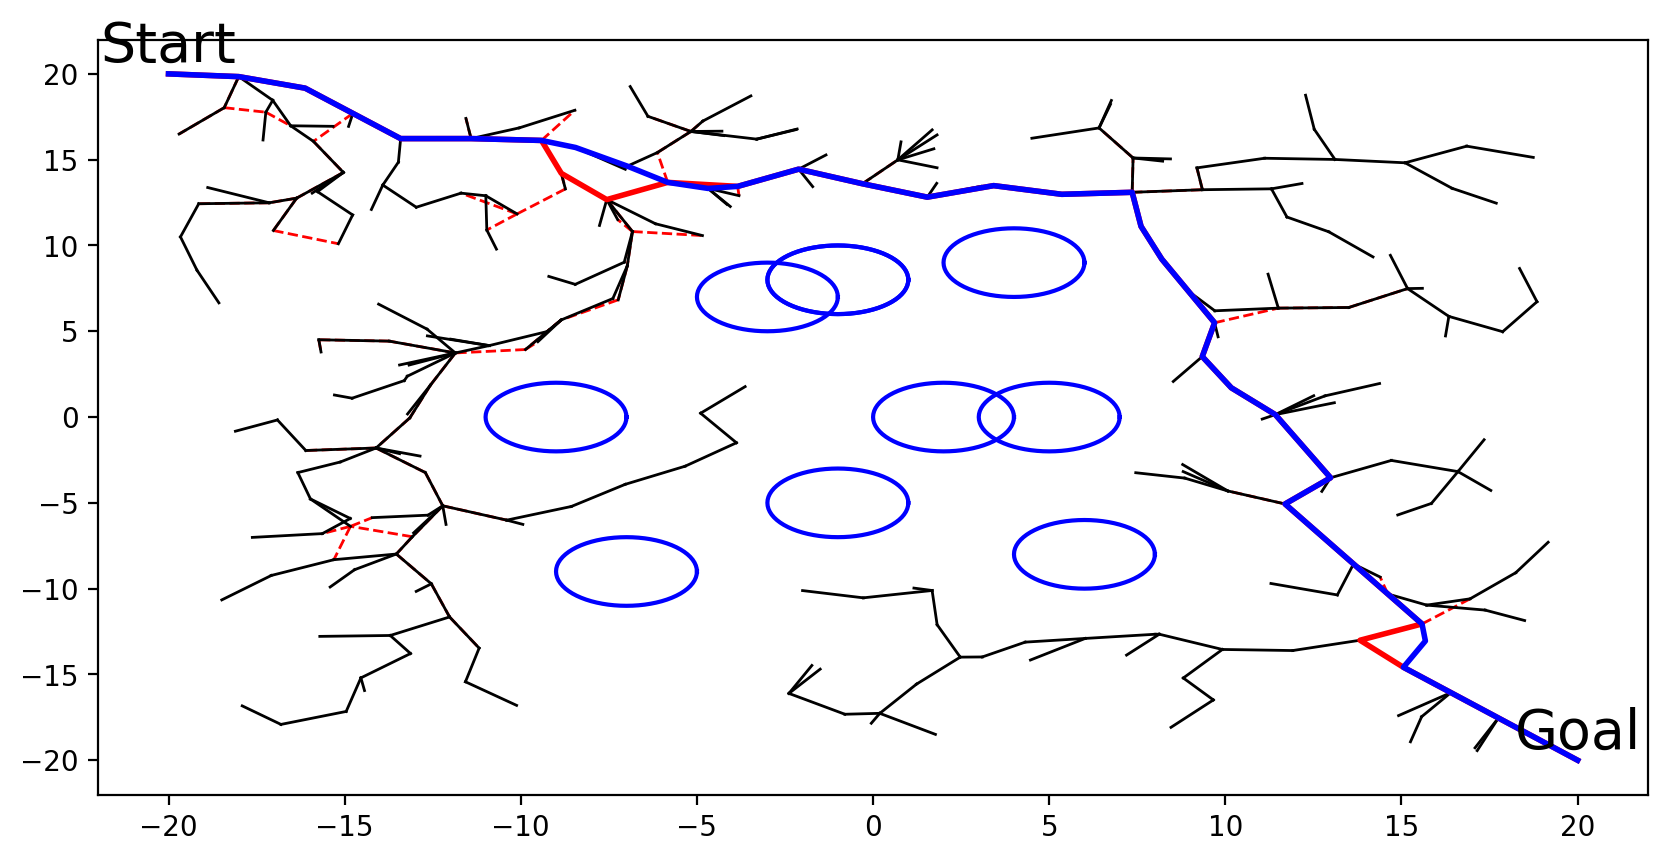

In [12]:
if __name__ == "__main__":
    plt.rcParams['figure.dpi'] = 200

    env = Environment(x_min=-20, y_min=-20, x_max=20, y_max=20)

    circles = []
    radius = 2
    for i in range(10):
        x = random.choice([i for i in range(-10, 10)])
        y = random.choice([i for i in range(-10, 10)])
        circles.append((x, y, radius))
    env.add_obstacle(circles)

    start_point = np.array([-20, 20])
    goal_point  = np.array([20, -20])

    planner = RRTStar( env, 
                       start=start_point, 
                       goal=goal_point, 
                       delta_distance=2,
                       gamma_RRT_star=100,
                       epsilon=0.2, 
                       max_iter=500)

    path, init_path = planner.generate_path()
    tree = planner.get_rrt_tree()
    test_tree = planner.test_get_rrt_tree()

    # Plot
    for circle in circles:
        plot_circle(circle[0], circle[1], circle[2])

    for vertex in test_tree:
        plt.plot([x for (x, y) in vertex],[y for (x, y) in vertex], '--r', linewidth=1,)

    for vertex in tree:
        plt.plot([x for (x, y) in vertex],[y for (x, y) in vertex], 'k', linewidth=1,)

    if path is None:
        print("cannot create path")
    else:
        plt.scatter([x for (x, y) in path], [y for (x, y) in path], s=55, c = 'g')
        plt.plot([x for (x, y) in init_path], [y for (x, y) in init_path], '-r',  linewidth=2)
        plt.plot([x for (x, y) in path], [y for (x, y) in path], '-b',  linewidth=2)
        plt.text(path[0][0], path[0][1], 'Start', verticalalignment='bottom', horizontalalignment='center', size="20")
        plt.text(path[-1][0], path[-1][1], 'Goal', verticalalignment='bottom', horizontalalignment='center', size="20")
    plt.show()